In [36]:
from bs4 import BeautifulSoup
from html import unescape
import pandas as pd
from gensim.utils import simple_preprocess
import gensim
import spacy
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import pickle


In [65]:
print(tf.__version__)

2.16.1


In [28]:
train_data_csv = "Data/train.csv" # Path to the training data
test_data_csv = "Data/test.csv" # Path to the test data
train_data = pd.read_csv(train_data_csv)
test_data = pd.read_csv(test_data_csv)


In [29]:
def semi_clean_data(data):
    semi_clean_data = []
    for i in range(len(data)):
        email_body = str(data['body'][i]) # Extract the email body
        email_body = unescape(email_body)  # Convert HTML entities to unicode
        email_body = BeautifulSoup(email_body) # Remove HTML tags
        semi_clean_email_body = email_body.get_text() # Extract the text from the email body
        semi_clean_data.append(semi_clean_email_body)
    return semi_clean_data

In [30]:
semi_clean_train_data = semi_clean_data(train_data) # Semi-clean the training data
semi_clean_test_data = semi_clean_data(test_data) # Semi-clean the test data
train_data['semi_clean_body'] = semi_clean_train_data
test_data['semi_clean_body'] = semi_clean_test_data

c:\Users\dhruv\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\dhruv\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [31]:
!python -m spacy download en_core_web_sm # Download the English model for spacy

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [32]:
def clean_data(data):
    clean_data = []
    nlp = spacy.load('en_core_web_sm') # Load the English model for spacy
    for i in range(len(data)):
        semi_clean_email_body = data['semi_clean_body'][i]
        tokens_no_sw = [token for token in simple_preprocess(semi_clean_email_body) if token not in gensim.parsing.preprocessing.STOPWORDS] # Remove stopwords
        clean_email_body = nlp(" ".join(tokens_no_sw)) # Lemmatize the email body
        clean_data.append(str(clean_email_body))
    return clean_data

In [33]:
train_data['clean_body'] = clean_data(train_data) # Clean the training data
test_data['clean_body'] = clean_data(test_data) # Clean the test data

In [35]:
# Vectorizataion of the data
encoder = tf.keras.layers.TextVectorization(max_tokens=10000) # Vectorize the data
encoder.adapt(train_data['clean_body'].values) # Fit the encoder on the training data
encoded_train_data = encoder(train_data['clean_body'].values) # Encode the training data
train_data['encoded_data'] = encoded_train_data.numpy().tolist() # Convert the encoded data to a list
test_data['encoded_data'] = encoder(test_data['clean_body'].values).numpy().tolist() # Encode the test data

In [37]:
pickle.dump({'config': encoder.get_config(),
             'weights': encoder.get_weights()}
            , open("tv_layer.pkl", "wb"))

In [9]:
#Model Params
input_dim = len(encoder.get_vocabulary())
input_shape = (len(train_data), )
output_len = 4
embedding_dim = 64
lstm_layer1_size = 64
lstm_layer2_size = 32
dense_layer1_size = 64
activation = 'relu'
num_epochs = 25


In [10]:
#Model
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=embedding_dim, input_shape=input_shape), # Embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_layer1_size, return_sequences=True)), # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_layer2_size)), # Bidirectional LSTM layer
    tf.keras.layers.Dense(dense_layer1_size, activation=activation), # Dense layer
    tf.keras.layers.Dense(output_len, activation='softmax') # Dense Output layer
])

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 2500, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2500, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,684 (2.87 MB)

 Trainable params: 751,684 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model

train_data['coded_label'] = train_data['label'].map({'student': 0, 'research': 1, 'corporate': 2, 'Other': 3}) # Map the labels to integers
test_data['coded_label'] = test_data['label'].map({'student': 0, 'research': 1, 'corporate': 2, 'Other': 3}) # Map the labels to integers

train_data['coded_label'] = pd.Categorical(train_data['coded_label'], categories = [0, 1, 2, 3]) # Convert the labels to categorical
test_data['coded_label'] = pd.Categorical(test_data['coded_label'], categories=[0, 1, 2, 3])# Convert the labels to categorical

train_one_hot_labels = pd.get_dummies(train_data['coded_label'], dummy_na = False).values # One-hot encode the labels
test_one_hot_labels = pd.get_dummies(test_data['coded_label'], dummy_na = False).values # One-hot encode the labels

x_train=[np.asarray(train_data_element).astype(np.int64) for train_data_element in train_data['encoded_data']] # Convert the training data to a numpy array
x_test=[np.asarray(test_data_element).astype(np.int64) for test_data_element in test_data['encoded_data']] # Convert the test data to a numpy array

y_train=[np.asarray(label).astype(np.int64) for label in train_one_hot_labels] # Convert the training labels to a numpy array
y_test=[np.asarray(label).astype(np.int64) for label in test_one_hot_labels] # Convert the test labels to a numpy array

# max_len = max(len(seq) for seq in x_train)
# pad_len = max(max_len, max(len(seq) for seq in x_test))
# x_train = pad_sequences(x_train, padding='post', maxlen = pad_len)
# x_test = pad_sequences(x_test, padding='post', maxlen = pad_len)

x_train = tf.stack(x_train) # Stack the training data
y_train = tf.stack(y_train) 
x_test = tf.stack(x_test) # Stack the test data
y_test = tf.stack(y_test)

In [14]:
if tf.config.list_physical_devices('GPU'): # Check if GPU is available
    print("Training on GPU...")
else:
    print("GPU not available, training on CPU...")
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data = (x_test, y_test)) # Train the model

Training on GPU...
Epoch 1/25


2024-10-11 08:46:43.864867: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.5681 - loss: 0.9955 - val_accuracy: 0.8220 - val_loss: 0.5427
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.8480 - loss: 0.4803 - val_accuracy: 0.8300 - val_loss: 0.5099
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.8930 - loss: 0.3670 - val_accuracy: 0.8300 - val_loss: 0.5459
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9126 - loss: 0.3166 - val_accuracy: 0.8260 - val_loss: 0.5789
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.9272 - loss: 0.2589 - val_accuracy: 0.8400 - val_loss: 0.5706
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.9382 - loss: 0.2034 - val_accuracy: 0.8320 - val_loss: 0.5427
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9429 - loss: 0.1890 - val_accuracy: 0.8320 - val_loss: 0.5596
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.9388 - loss: 0.1871 - val_accuracy: 0.828

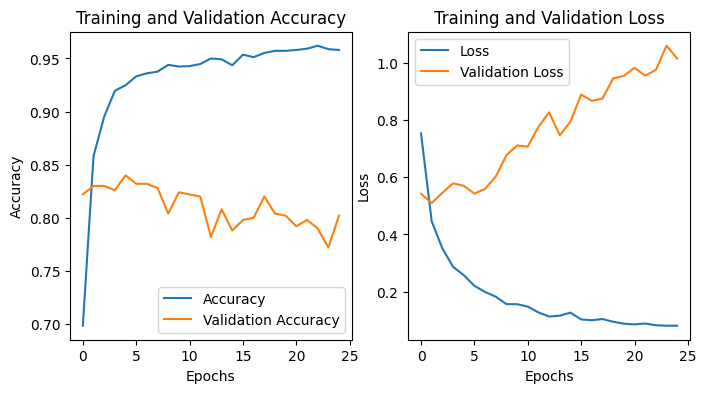

In [15]:
from matplotlib import pyplot as plt

history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [16]:
pred = model.predict(x_test) # Predict the test data
pred_labels = np.argmax(pred, axis=1)
test_data['Predicted_Label'] = pred_labels

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [17]:
pred = model.predict(x_train) # Predict the training data
pred_labels = np.argmax(pred, axis=1)
train_data['Predicted_Label'] = pred_labels

 6/79 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step


In [18]:
y_true = test_data['coded_label']
y_pred = test_data['Predicted_Label']

# precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision}')

#  recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall}')

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

Precision: 0.8155301056853235
Recall: 0.802
Confusion Matrix:
[[ 85   9  24   5]
 [  3 150  11   1]
 [ 18  11 166  10]
 [  0   1   6   0]]


In [19]:
y_true = train_data['coded_label']
y_pred = train_data['Predicted_Label']

# precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision}')

#  recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall}')

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

Precision: 0.9666638087981526
Recall: 0.966
Confusion Matrix:
[[ 465    4   30    4]
 [   3  898   21    0]
 [   2   15 1023    2]
 [   0    1    3   29]]


In [20]:
model.save('best_scratch_model.keras') # Save the model

In [ ]:
def predict_using_scratch_model(body, model, encoder):
    def semi_clean_data(data):
        semi_clean_data = []
        for i in range(len(data)):
            email_body = str(data['body'][i]) # Extract the email body
            email_body = unescape(email_body)  # Convert HTML entities to unicode
            email_body = BeautifulSoup(email_body) # Remove HTML tags
            semi_clean_email_body = email_body.get_text() # Extract the text from the email body
            semi_clean_data.append(semi_clean_email_body)
        return semi_clean_data
    
    def clean_data(data):
        clean_data = []
        nlp = spacy.load('en_core_web_sm') # Load the English model for spacy
        for i in range(len(data)):
            semi_clean_email_body = data['semi_clean_body'][i]
            tokens_no_sw = [token for token in simple_preprocess(semi_clean_email_body) if token not in gensim.parsing.preprocessing.STOPWORDS] # Remove stopwords
            clean_email_body = nlp(" ".join(tokens_no_sw)) # Lemmatize the email body
            clean_data.append(str(clean_email_body))
        return clean_data
    
    data = {'body': body}
    df = pd.DataFrame(data, index=[0])
    semi_clean_test_data = semi_clean_data(df) # Semi-clean the test data
    df['semi_clean_body'] = semi_clean_test_data
    clean_test_data = clean_data(df) # Clean the test data
    df['clean_body'] = clean_test_data # Clean the test data
    df['encoded_data'] = encoder(df['clean_body'].values).numpy().tolist() # Encode the test data
    x_test=[np.asarray(test_data_element).astype(np.int64) for test_data_element in df['encoded_data']] # Convert the test data to a numpy array
    x_test = tf.stack(x_test) # Stack the test data

    predicted_label = model.predict(x_test)
    predicted_label = np.argmax(predicted_label)

    codes = {0: 'student', 1: 'research', 2: 'corporate', 3: 'Other'}
    return codes[predicted_label]

In [ ]:
#Model
new_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_shape=(None, )), # Embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # Bidirectional LSTM layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(4, activation='softmax') # Dense Output layer
])

new_model.load_weights("best_scratch_model.keras")

from_disk = pickle.load(open("tv_layer.pkl", "rb")) 
new_encoder = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
new_encoder.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
new_encoder.set_weights(from_disk['weights'])

In [ ]:
email_body = "Hello Please provide me the course content"
predicted_label = predict_using_scratch_model(email_body, new_model, new_encoder)